In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import math
import os

from pandas_datareader import data as wb

import seaborn as sns
import scipy.optimize as sco
import quandl

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
stocks=["RELIANCE.NS","ICICIBANK.NS","L&TFH.NS","SAIL.NS"]
start="2019-01-01"
end="2019-08-01"
n_simulations=25000
n_days=252
bond_rate=0.0178
no_of_stocks=len(stocks)

In [4]:
def get_data(stocks):
    result_df=pd.DataFrame()
    for i in stocks:
        df=wb.DataReader(i,"yahoo",start,end)
        #df["Ticker"]=i
        #df=df[["Ticker","Adj Close",]]
        
        new_df=pd.DataFrame()
        new_df[i]=df["Adj Close"]
        #new_df=df.pivot(columns="Ticker")
        #new_df.columns=[col[1] for col in new_df.columns]
        
        result_df=pd.concat([result_df,new_df],axis=1)
        
    return result_df

In [5]:
df=get_data(stocks)

In [6]:
def visualise_data(df):
    pct_returns=df.pct_change()
    
    plt.figure(figsize=(16,8))
    for column in pct_returns.columns.values:
        plt.plot(pct_returns.index,pct_returns[column],lw=3,alpha=0.8,label=column)
        plt.legend(loc="lower right",fontsize=10)
        plt.ylabel("Daily Percentage Returns")

C:\Users\Ayush\Anaconda2019\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


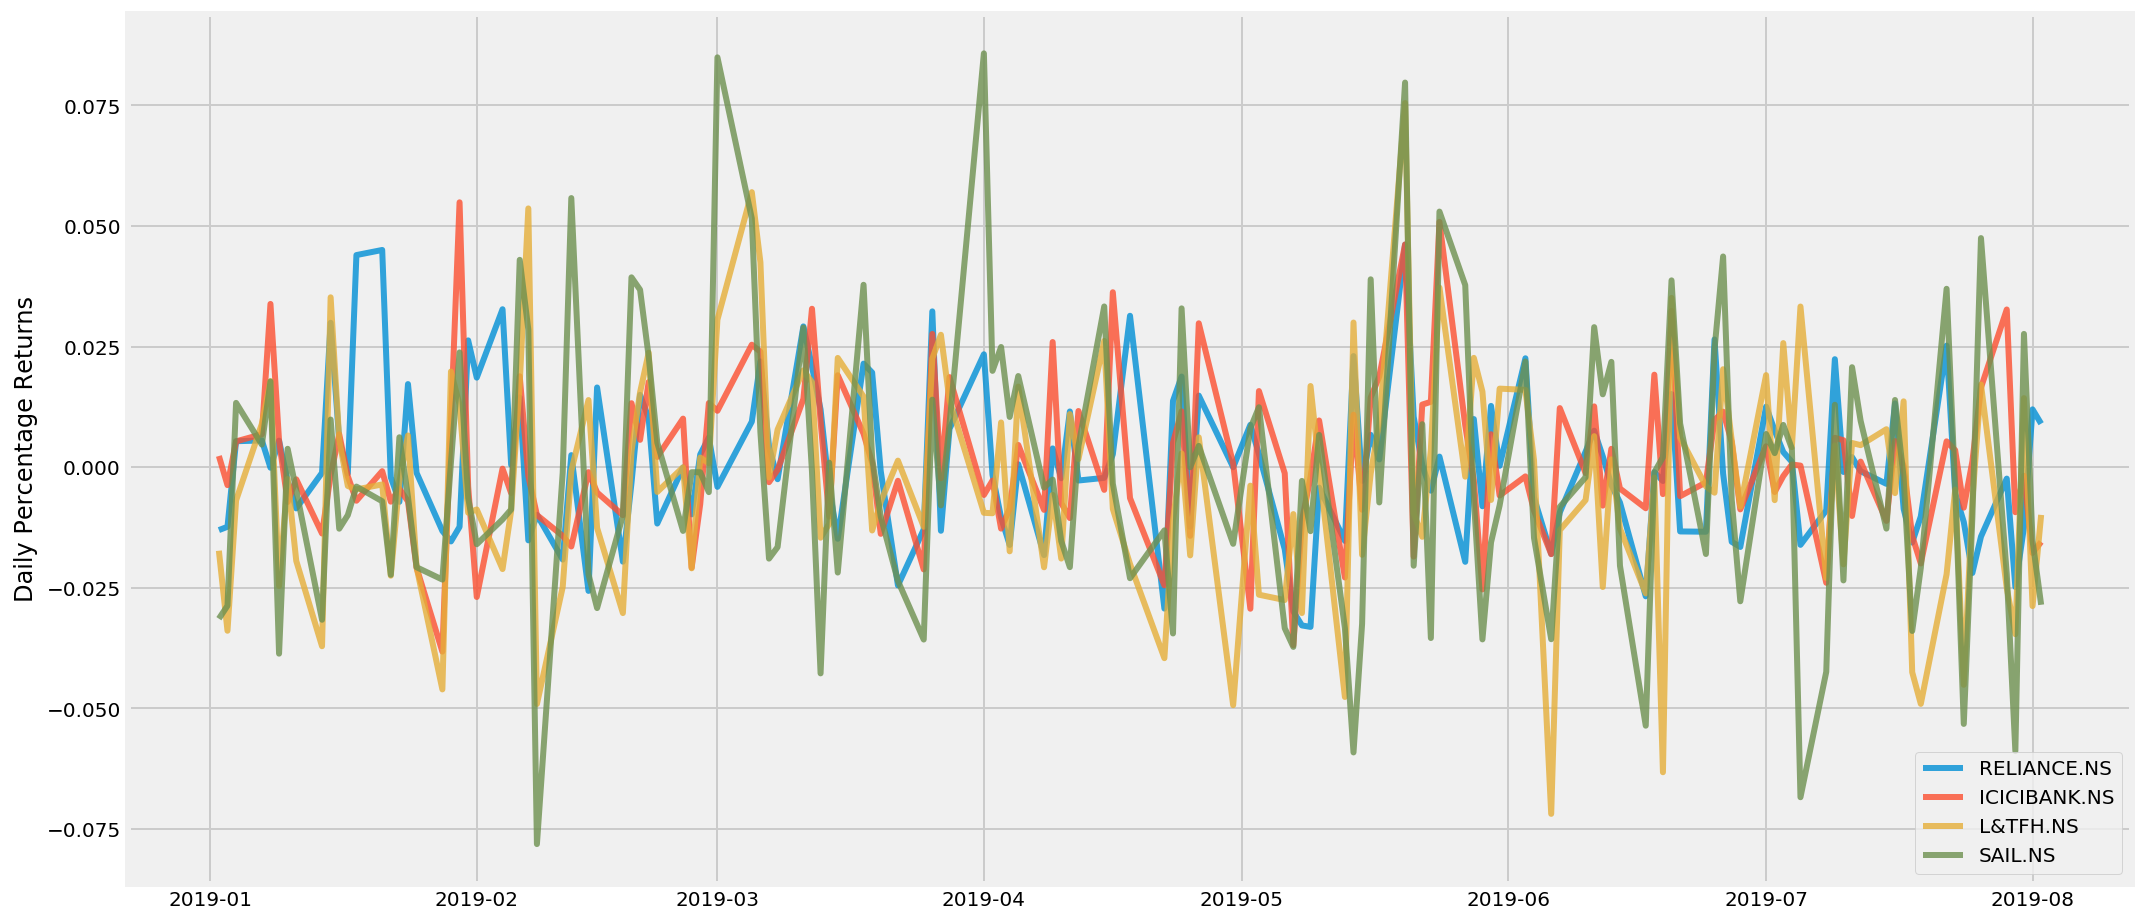

In [7]:
visualise_data(df)

In [8]:
def portfolio_performance(weights,mean_returns,cov_matrix,no_of_days):
    returns=np.sum(mean_returns*weights)*no_of_days
    std=np.sqrt(np.dot(weights.T,np.dot(cov_matrix,weights)))*np.sqrt(no_of_days)
    return returns,std

def portfolio_simulator(n_days,n_stocks,n_simulations,mean_returns,cov_matrix,bond_rate):
    results=np.zeros((3,n_simulations))
    weight_array=[]
    for i in range(n_simulations):
        weights=np.random.rand(n_stocks)
        weights/=np.sum(weights)
        weight_array.append(weights)
        stdv,returns,=portfolio_performance(weights,mean_returns,cov_matrix,n_days)
        results[0,i]=stdv
        results[1,i]=returns
        #Sharpe Ratio
        results[2,i]=(returns-bond_rate)/stdv
    return results,weight_array

In [9]:
returns=df.pct_change()
mean_returns=returns.mean()
cov_matrix=returns.cov()

In [12]:
cov_matrix

,RELIANCE.NS,ICICIBANK.NS,L&TFH.NS,SAIL.NS
RELIANCE.NS,0.000249,0.000079,0.000113,0.000145
ICICIBANK.NS,0.000079,0.000251,0.000190,0.000193
L&TFH.NS,0.000113,0.000190,0.000531,0.000333
SAIL.NS,0.000145,0.000193,0.000333,0.000798


In [14]:
def visualise_simulated_ef_random_weights(df,mean_returns,cov_matrix,n_simulations,bond_rate,n_stocks):
    results,weights=portfolio_simulator(no_of_stocks,n_simulations,mean_returns,cov_marix,bond_rate)
    
    max_sharpe_idx=np.argmax(results[2])
    sdp,rp=results[0,max_sharpe_idx],results[1,max_sharpe_idx]
    max_sharpe_allocation=pd.DataFrame(weights[max_sharpe_idx],index=df.columns,columns=["allocation"])
    max_sharpe_allocation.allocation=[round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation=max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [15]:
def neg_sharpe_ratio(weights,mean_returns,cov_matrix,bond_rate,ndays):
    p_var,p_ret=portfolio_performance(weights,mean_returns,cov_matrix,ndays)
    return -(p_ret-bond_free_rate)/p_var

def max_sharpe_ratio(mean_returns,cov_matrix,bond_rate):
    n_assets=len(mean_returns)
    args=(mean_returns,cov_matrix,bond_rate)
    constraints=({"type":"eq","fun" : lambda x: np.sum(x)-1})
    bound=(0.0,1.0)
    bounds=tuple(bound for asset in range(n_assets))
    result=sco.minimize(neg_sharpe_ratio,n_assets*[1./n_assets],args=args,method="SLSQP",bounds=bounds,constraints=constraints)
    return result

def portfolio_volatility(n_days,weights,mean_returns,cov_matrix):
    return portfolio_simulator(n_days,weights,mean_returns.cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result